In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 이슈 해결 - 로컬
import os
import matplotlib.pyplot as plt
if os.name == "posix":
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

In [3]:
df = pd.read_csv('cleaned_hotel_bookings.csv')

## 가설 5: 식사 유형 별로 예약 취소율은 다를 것이다.

### 5-1. 식사 유형 별 예약 수와 취소 수

In [4]:
# 각 식사 유형별 예약 및 취소 수 계산
meal_stats = df.groupby('meal').agg(
    total_reservations=('is_canceled', 'count'),
    canceled_reservations=('is_canceled', 'sum')
).reset_index()

# 전체 예약 중 각 식사 유형의 비율 계산
total_reservations = df.shape[0]
meal_stats['proportion_of_total'] = meal_stats['total_reservations'] / total_reservations * 100

meal_stats

,meal,total_reservations,canceled_reservations,proportion_of_total
0,BB,92309,34510,77.317843
1,FB,798,478,0.668403
2,HB,14463,4984,12.114181
3,SC,10650,3966,8.920420
4,Undefined,1169,286,0.979152


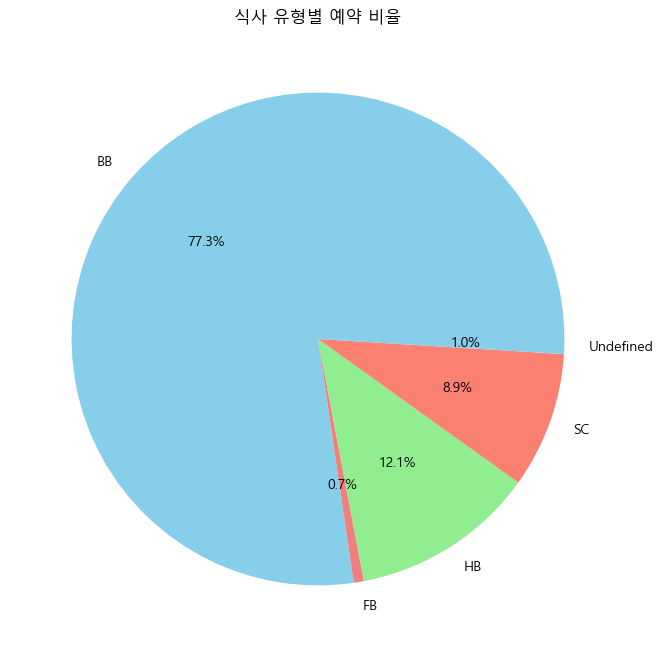

In [5]:
# 시각화
plt.figure(figsize=(8, 8))
plt.pie(meal_stats['total_reservations'], labels=meal_stats['meal'], autopct='%1.1f%%', 
        colors=['skyblue', 'lightcoral', 'lightgreen', 'salmon'])
plt.title('식사 유형별 예약 비율')
plt.show()

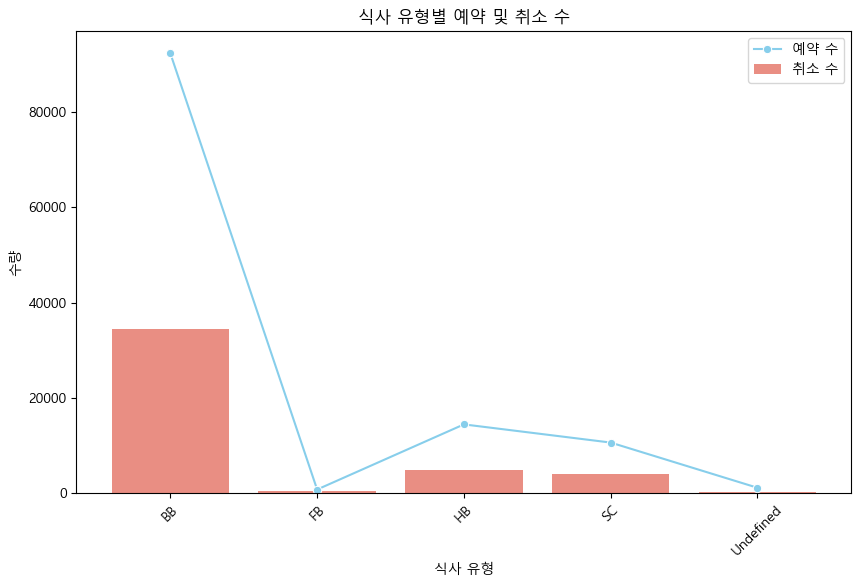

In [6]:
# 시각화
plt.figure(figsize=(10, 6))

# 막대 그래프 (취소 수)
sns.barplot(data=meal_stats, x='meal', y='canceled_reservations', color='salmon', label='취소 수')

# 선 그래프 (예약 수)
sns.lineplot(data=meal_stats, x='meal', y='total_reservations', color='skyblue', marker='o', label='예약 수')

plt.title('식사 유형별 예약 및 취소 수')
plt.xlabel('식사 유형')
plt.ylabel('수량')
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 5-2. 식사 유형 별 취소율

In [7]:
# 식사 유형별 예약 취소 비율 계산
cancellation_rates = df.groupby('meal')['is_canceled'].mean()
cancellation_rates.sort_values(ascending=False)

meal
FB           0.598997
BB           0.373853
SC           0.372394
HB           0.344603
Undefined    0.244654
Name: is_canceled, dtype: float64

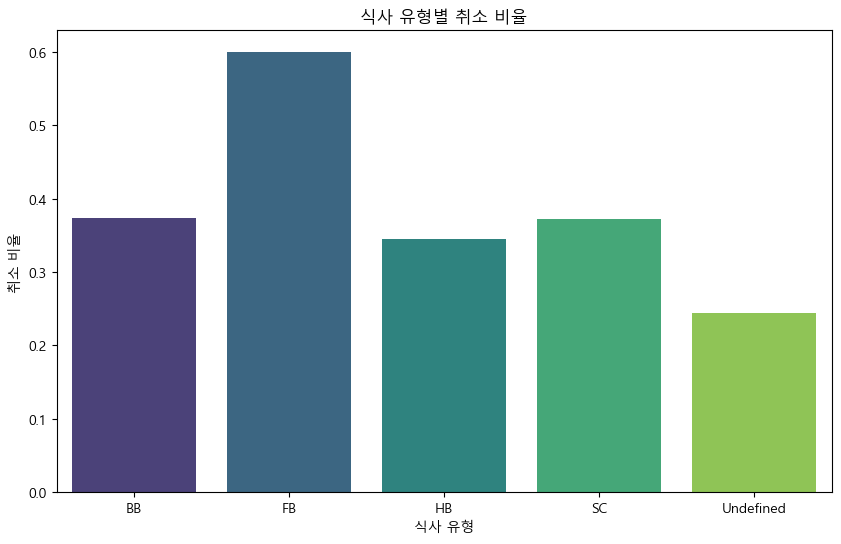

In [8]:
# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=cancellation_rates.index, y=cancellation_rates.values, palette="viridis")
plt.title('식사 유형별 취소 비율')
plt.xlabel('식사 유형')
plt.ylabel('취소 비율')
plt.show()

### 5-3. 고객 유형 재계산

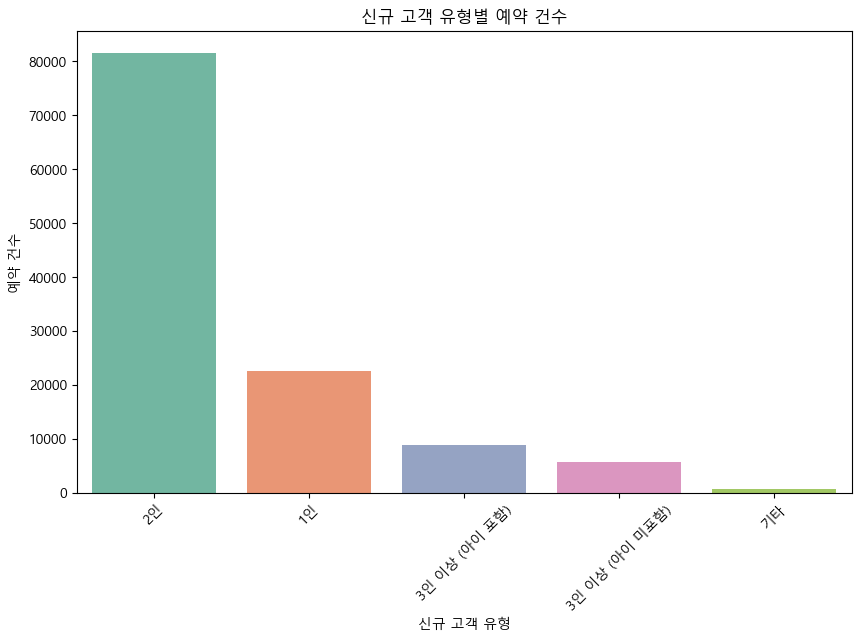

2인                81559
1인                22577
3인 이상 (아이 포함)      8837
3인 이상 (아이 미포함)     5741
기타                  675
Name: new_customer_type, dtype: int64

In [9]:
# 총 인원 수 계산 (성인 + 아이 + 유아)
df['total_people'] = df['adults'] + df['children'] + df['babies']

# 고객 유형 분류
def classify_customer_type(row):
    if row['adults'] == 1 and row['total_people'] == 1:
        return '1인'
    elif row['adults'] == 2 and row['total_people'] == 2:
        return '2인'
    elif row['adults'] >= 3 and row['total_people'] == row['adults']:
        return '3인 이상 (아이 미포함)'
    elif row['total_people'] >= 3:
        return '3인 이상 (아이 포함)'
    else:
        return '기타'

# 새로운 고객 유형 열 생성
df['new_customer_type'] = df.apply(classify_customer_type, axis=1)

# 새로운 고객 유형별 예약 수 계산
new_customer_type_counts = df['new_customer_type'].value_counts()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=new_customer_type_counts.index, y=new_customer_type_counts.values, palette="Set2")
plt.title('신규 고객 유형별 예약 건수')
plt.xlabel('신규 고객 유형')
plt.ylabel('예약 건수')
plt.xticks(rotation=45)
plt.show()

new_customer_type_counts

### 5-4. 고객 유형 별 식사 선호도

In [10]:
# 각 예약별 총 인원 수 계산
df['total_people'] = df['adults'] + df['children'] + df['babies']

# 전체 인원 수 및 성인 수를 기반으로 신규 고객 유형 분류
df['new_customer_type'] = df.apply(classify_customer_type, axis=1)

# 각 식사 유형별 신규 고객 유형의 수 계산
meal_customer_type_distribution = df.groupby(['meal', 'new_customer_type']).size().unstack(fill_value=0)

# 분포 표시 및 그래프 작성
meal_customer_type_distribution

new_customer_type,1인,2인,3인 이상 (아이 미포함),3인 이상 (아이 포함),기타
meal,,,,,
BB,19107,60566,4952,7199,485
FB,72,603,39,81,3
HB,1713,10736,620,1346,48
SC,1436,8834,87,154,139
Undefined,249,820,43,57,0


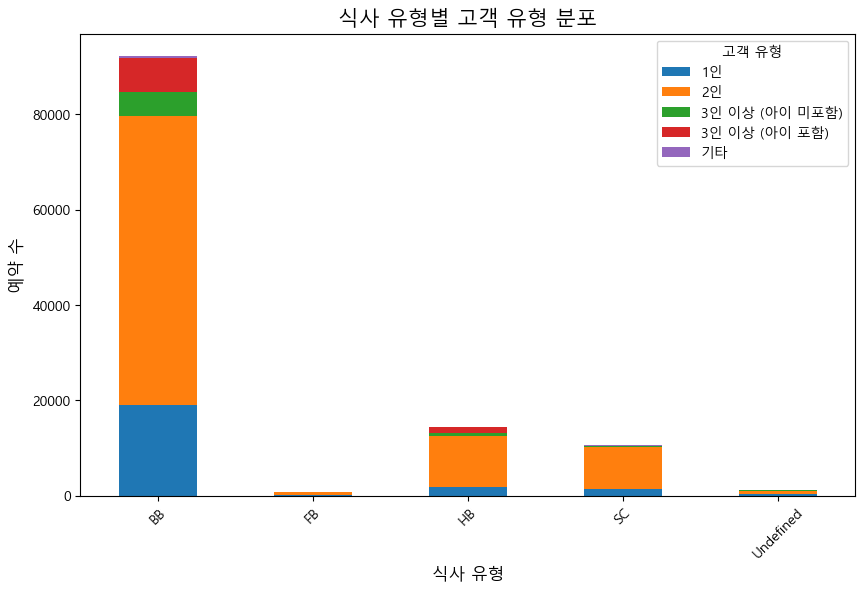

In [11]:
# 결과를 막대 그래프로 표시
ax = meal_customer_type_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('식사 유형별 고객 유형 분포', fontsize=15)
plt.xlabel('식사 유형', fontsize=12)
plt.ylabel('예약 수', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='고객 유형', fontsize=10)
plt.show()

### 5-5. 식사 유형 별 고객 유형에 따른 취소율
#### 5-5-1. 고객 유형 별 식사 취소율

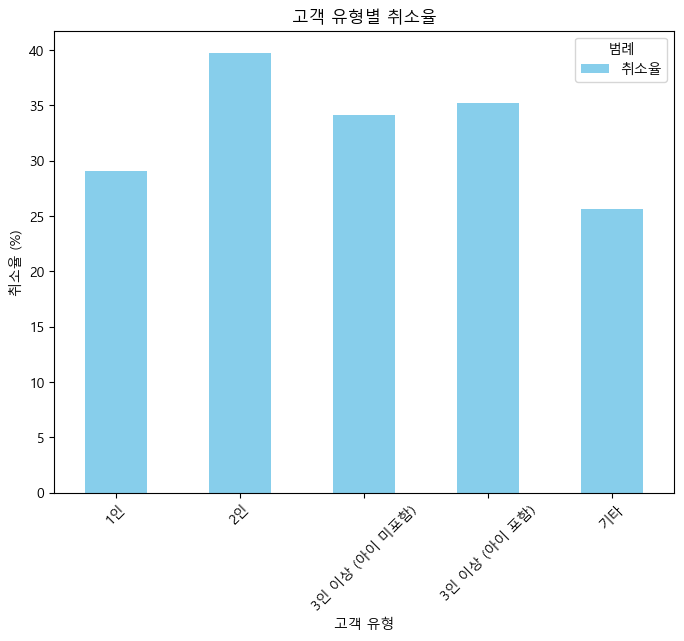

new_customer_type
1인                29.033973
2인                39.755269
3인 이상 (아이 미포함)    34.157812
3인 이상 (아이 포함)     35.204255
기타                25.629630
Name: new_customer_type, dtype: float64

In [12]:
# 각 고객 유형별 식사 취소율 계산
cancelled_by_customer_type = df[df['is_canceled'] == 1].groupby('new_customer_type')[
    'new_customer_type'].count() / df.groupby('new_customer_type')['new_customer_type'].count() * 100

# 시각화
plt.figure(figsize=(8, 6))
cancelled_by_customer_type.plot(kind='bar', color='skyblue')
plt.title('고객 유형별 취소율')
plt.xlabel('고객 유형')
plt.ylabel('취소율 (%)')
plt.xticks(rotation=45)
plt.legend(['취소율'], fontsize=10, title='범례')
plt.show()

cancelled_by_customer_type

#### 5-5-2. 식사 유형 별 고객 유형에 따른 취소율

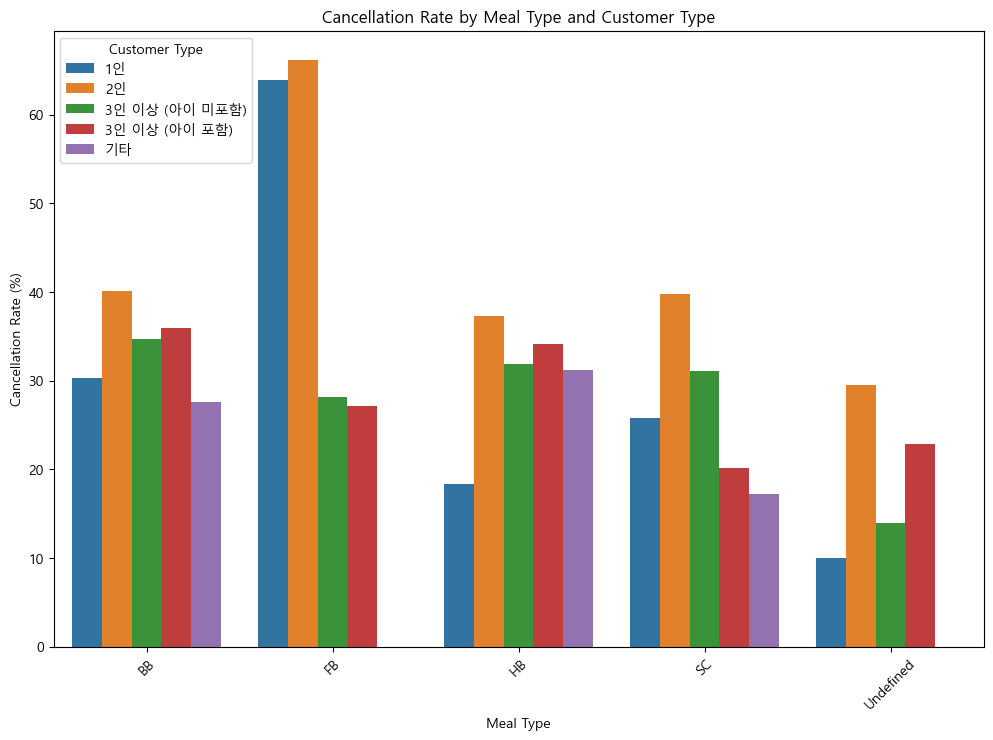

In [13]:
# 각 식사 유형별로 고객 유형에 따른 취소율 계산
cancelled_by_meal_and_customer_type = df[df['is_canceled'] == 1].groupby(
    ['meal', 'new_customer_type'])['new_customer_type'].count() / df.groupby(
    ['meal', 'new_customer_type'])['new_customer_type'].count() * 100
cancelled_by_meal_and_customer_type = cancelled_by_meal_and_customer_type.reset_index(name='Cancellation Rate')

# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='meal', y='Cancellation Rate', hue='new_customer_type', data=cancelled_by_meal_and_customer_type)
plt.title('Cancellation Rate by Meal Type and Customer Type')
plt.xlabel('Meal Type')
plt.ylabel('Cancellation Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Customer Type')
plt.show()

## 가설 6: 휴가철 기간은 비휴가철 기간보다 예약 취소율이 높을 것이다.

### 6-1. 휴가/비휴가 예약수

In [14]:
# 가설 검증을 위해 필요한 변수 선택
selected_data = df[['arrival_date_month', 'is_canceled']].copy()

# 휴가 시즌과 비휴가 시즌을 정의하기 위한 기준 설정 (여름: 6월부터 9월까지, 나머지는 비휴가 시즌)
vacation_season = ['June', 'July', 'August', 'September']

# arrival_date_month를 통해 휴가 시즌 여부 파악
selected_data['vacation_season'] = selected_data['arrival_date_month'].apply(lambda x: 'Vacation' if x in vacation_season 
                                                                             else 'Non-Vacation')

# 휴가 시즌과 비휴가 시즌에 따른 예약 개수 계산
reservation_counts_by_season = selected_data['vacation_season'].value_counts()

reservation_counts_by_season


Non-Vacation    71404
Vacation        47985
Name: vacation_season, dtype: int64

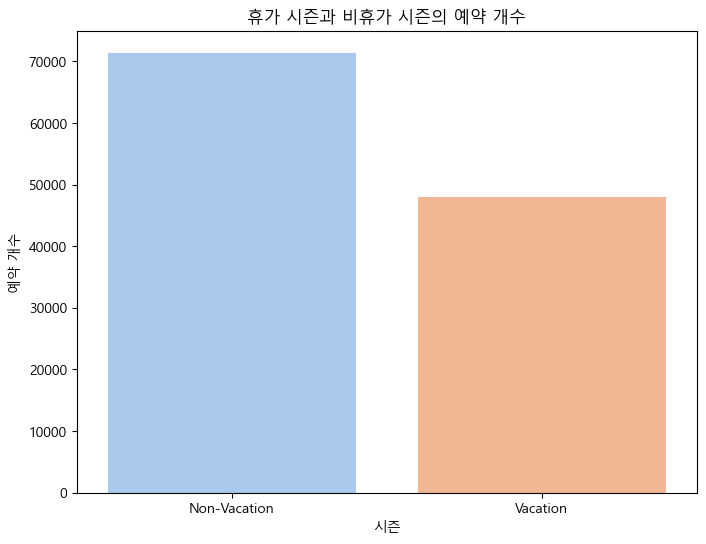

In [15]:
# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=reservation_counts_by_season.index, y=reservation_counts_by_season.values, palette='pastel')
plt.title('휴가 시즌과 비휴가 시즌의 예약 개수')
plt.xlabel('시즌')
plt.ylabel('예약 개수')
plt.show()

### 6-2. 휴가/비휴가 취소수

In [16]:
# 휴가 시즌과 비휴가 시즌을 정의하기 위한 기준 설정 (여름: 6월부터 9월까지, 나머지는 비휴가 시즌)
vacation_season = ['June', 'July', 'August', 'September']

# arrival_date_month를 통해 휴가 시즌 여부 파악
selected_data['vacation_season'] = selected_data['arrival_date_month'].apply(lambda x: 'Vacation' if x in vacation_season 
                                                                             else 'Non-Vacation')

# 휴가 시즌과 비휴가 시즌에 따른 예약 취소 개수 계산
cancel_counts_by_season = selected_data[selected_data['is_canceled'] == 1]['vacation_season'].value_counts()

cancel_counts_by_season

Non-Vacation    25592
Vacation        18632
Name: vacation_season, dtype: int64

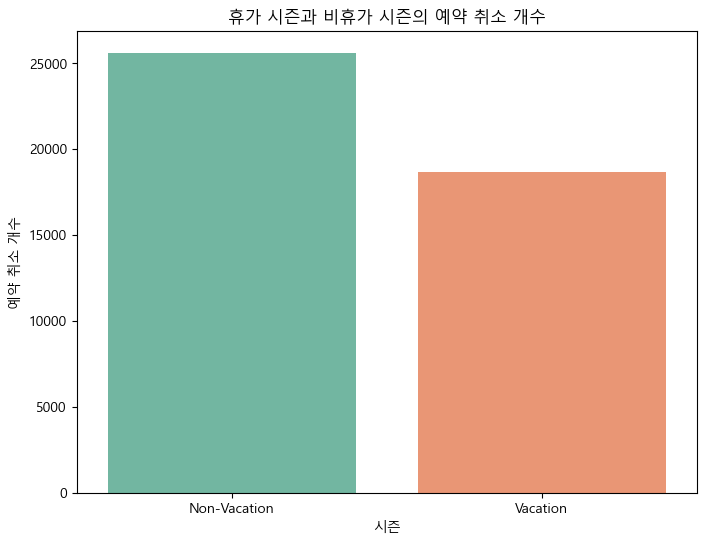

In [17]:
# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=cancel_counts_by_season.index, y=cancel_counts_by_season.values, palette='Set2')
plt.title('휴가 시즌과 비휴가 시즌의 예약 취소 개수')
plt.xlabel('시즌')
plt.ylabel('예약 취소 개수')
plt.show()

### 6-3. 휴가/비시즌 취소율

In [18]:
# 가설 검증을 위해 필요한 변수 선택
selected_data = df[['arrival_date_month', 'is_canceled']].copy()

# 휴가 시즌과 비휴가 시즌을 정의하기 위한 기준 설정 (여름: 6월부터 9월까지, 겨울: 12월부터 2월까지)
vacation_season = ['June', 'July', 'August', 'September']

# arrival_date_month를 통해 휴가 시즌 여부 파악
selected_data['vacation_season'] = selected_data['arrival_date_month'].apply(lambda x: 'Vacation' if x in vacation_season 
                                                                             else 'Non-Vacation')

# 휴가 시즌과 비휴가 시즌에 따른 예약 취소 비율 계산
cancel_ratio_by_season = selected_data.groupby('vacation_season')['is_canceled'].mean()

cancel_ratio_by_season

vacation_season
Non-Vacation    0.358411
Vacation        0.388288
Name: is_canceled, dtype: float64

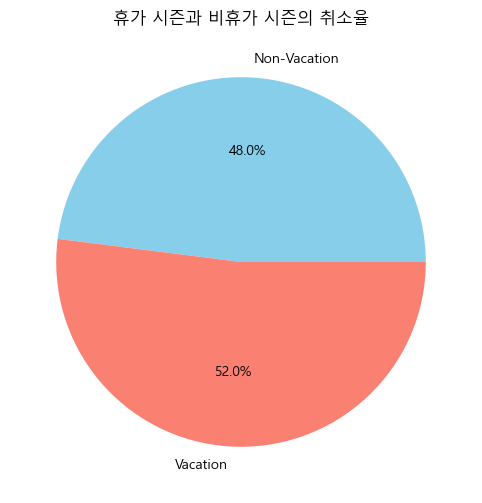

In [19]:
# 시각화
plt.figure(figsize=(8, 6))
plt.pie(cancel_ratio_by_season, labels=cancel_ratio_by_season.index, autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('휴가 시즌과 비휴가 시즌의 취소율')
plt.show()

### 6-4. 월별 취소율(상위, 하위)

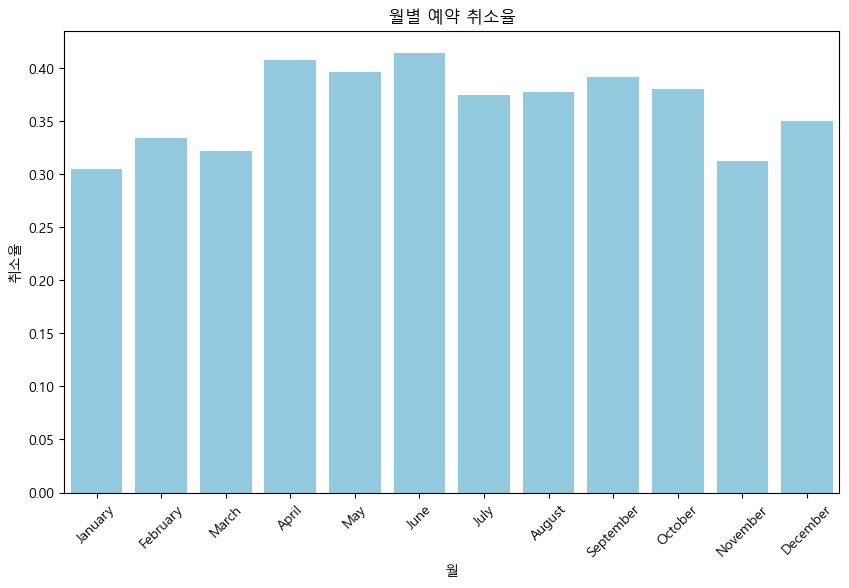

In [20]:
# 월별 취소된 예약 수 계산
cancelled_reservations_by_month = selected_data[selected_data['is_canceled'] == 1]['arrival_date_month'].value_counts()

# 전체 예약 수 계산
total_reservations_by_month = selected_data['arrival_date_month'].value_counts()

# 취소율 계산
cancel_ratio_by_month = cancelled_reservations_by_month / total_reservations_by_month

# 월 순서를 정의
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# 데이터프레임 재구성
cancel_ratio_by_month_df = cancel_ratio_by_month.reset_index()
cancel_ratio_by_month_df.columns = ['Month', 'Cancellation Rate']
cancel_ratio_by_month_df['Month'] = pd.Categorical(cancel_ratio_by_month_df['Month'], categories=months_order, ordered=True)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=cancel_ratio_by_month_df, x='Month', y='Cancellation Rate', color='skyblue')
plt.title('월별 예약 취소율')
plt.xlabel('월')
plt.ylabel('취소율')
plt.xticks(rotation=45)
plt.show()

#### 6-4-1. 취소율이 높은 달

In [21]:
# 취소율이 높은 순으로 정렬
cancel_ratio_sorted = cancel_ratio_by_month.sort_values(ascending=False)

# 상위 3개의 달 선택
top3_cancel_months = cancel_ratio_sorted.head(3)

top3_cancel_months

June     0.414572
April    0.407972
May      0.396658
Name: arrival_date_month, dtype: float64

#### 6-4-2. 취소율이 낮은 달

In [22]:
# 취소율이 낮은 순으로 정렬
cancel_ratio_sorted = cancel_ratio_by_month.sort_values()

# 하위 3개의 달 선택
top3_lowest_cancel_months = cancel_ratio_sorted.head(3)

top3_lowest_cancel_months

January     0.304773
November    0.312334
March       0.321556
Name: arrival_date_month, dtype: float64

### 6-5. 호텔별 월별 취소율

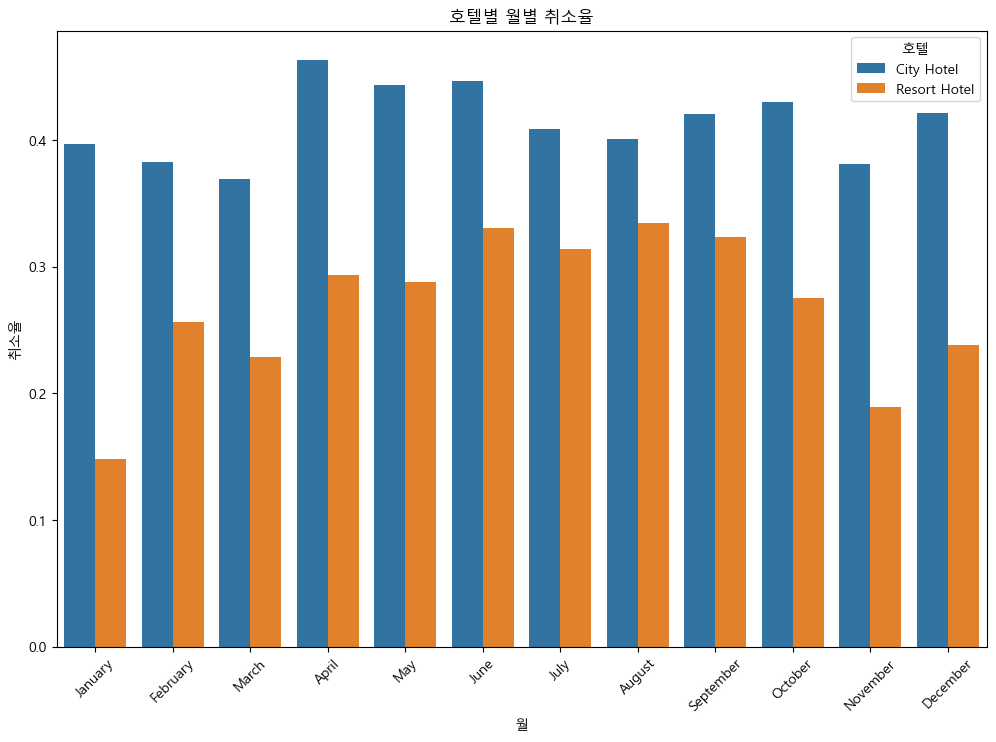

In [23]:
# 호텔별 취소율 계산
cancel_ratio_by_hotel_and_month = df.groupby(['hotel', 'arrival_date_month'])['is_canceled'].mean().reset_index()

# 월별 순서 설정
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# seaborn을 사용하여 그래프 그리기
sns.barplot(data=cancel_ratio_by_hotel_and_month, x='arrival_date_month', y='is_canceled', hue='hotel', order=month_order)

# 그래프 타이틀과 라벨 설정
plt.title('호텔별 월별 취소율')
plt.xlabel('월')
plt.ylabel('취소율')
plt.xticks(rotation=45)

# 범례 표시
plt.legend(title='호텔', loc='upper right')

# 그래프 보여주기
plt.show()

### 6-6. 호텔별 취소율 상위 3개의 달

In [24]:
# 취소율이 높은 순으로 정렬하여 상위 3개의 달 선택
top3_cancel_months_by_hotel = cancel_ratio_by_hotel_and_month.groupby('hotel').apply(lambda x: x.nlargest(3, 'is_canceled'))

top3_cancel_months_by_hotel

hotel arrival_date_month  is_canceled
hotel                                                        
City Hotel   0     City Hotel              April     0.463235
             6     City Hotel               June     0.446922
             8     City Hotel                May     0.443756
Resort Hotel 13  Resort Hotel             August     0.334491
             18  Resort Hotel               June     0.330706
             23  Resort Hotel          September     0.323681

### 6-7. 높은 예약 취소율 원인분석

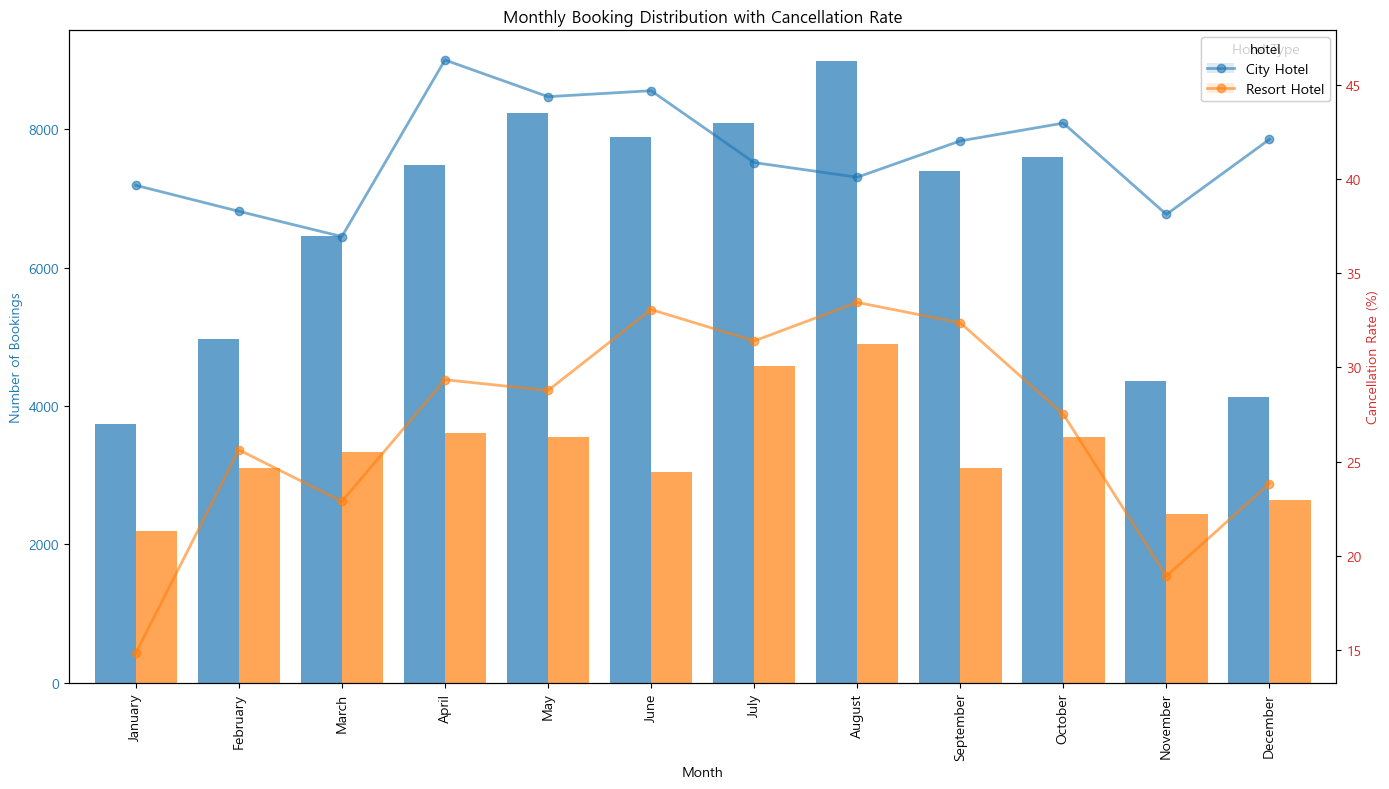

In [25]:
# 월별 총 예약 수와 취소된 예약 수 계산
monthly_total_bookings = df.groupby(['hotel', 'arrival_date_month']).size().unstack(fill_value=0).reindex(columns=months_order)
monthly_canceled_bookings = df[df['is_canceled'] == 1].groupby(['hotel', 'arrival_date_month']).size().unstack(fill_value=0).reindex(columns=months_order)

# 월별 취소율 계산
monthly_cancellation_rate = (monthly_canceled_bookings / monthly_total_bookings) * 100

# 바 그래프와 취소율 추세선 함께 작성
fig, ax1 = plt.subplots(figsize=(14, 8))

# 월별 예약자 수 바 그래프
monthly_total_bookings.T.plot(kind='bar', ax=ax1, width=0.8, alpha=0.7)
ax1.set_title('Monthly Booking Distribution with Cancellation Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Bookings', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(title='Hotel Type')

# 취소율 추세선
ax2 = ax1.twinx()
monthly_cancellation_rate.T.plot(ax=ax2, linestyle='-', marker='o', linewidth=2, alpha=0.6)
ax2.set_ylabel('Cancellation Rate (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(False)  # 기존 그리드 제거

fig.tight_layout()  # 레이아웃 조정

plt.show()

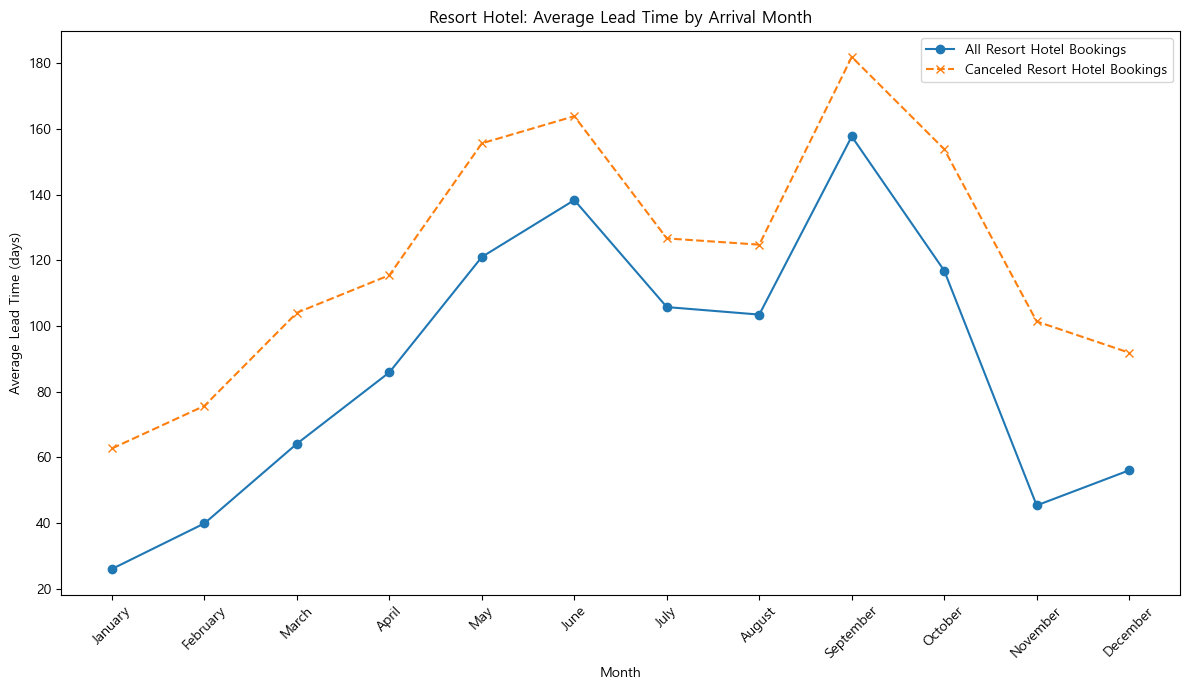

In [26]:
# Resort Hotel 데이터만 추출
resort_hotel_bookings = df[df['hotel'] == 'Resort Hotel']

# 월별로 그룹을 만들고 리드타임의 평균을 계산
monthly_avg_lead_time_resort = resort_hotel_bookings.groupby('arrival_date_month')['lead_time'].mean().reset_index()

# 예약이 취소된 Resort Hotel 데이터 추출
canceled_resort_bookings = resort_hotel_bookings[resort_hotel_bookings['is_canceled'] == 1]

# 예약 취소된 데이터에 대해 월별로 그룹을 만들고 리드타임의 평균을 계산
monthly_avg_lead_time_resort_canceled = canceled_resort_bookings.groupby('arrival_date_month')['lead_time'].mean().reset_index()

# 월 이름 순서 지정
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg_lead_time_resort['arrival_date_month'] = pd.Categorical(monthly_avg_lead_time_resort['arrival_date_month'], categories=months_order, ordered=True)
monthly_avg_lead_time_resort = monthly_avg_lead_time_resort.sort_values('arrival_date_month')

monthly_avg_lead_time_resort_canceled['arrival_date_month'] = pd.Categorical(monthly_avg_lead_time_resort_canceled['arrival_date_month'], categories=months_order, ordered=True)
monthly_avg_lead_time_resort_canceled = monthly_avg_lead_time_resort_canceled.sort_values('arrival_date_month')

# 시각화
plt.figure(figsize=(12, 7))
plt.plot(monthly_avg_lead_time_resort['arrival_date_month'], monthly_avg_lead_time_resort['lead_time'], marker='o', label='All Resort Hotel Bookings')
plt.plot(monthly_avg_lead_time_resort_canceled['arrival_date_month'], monthly_avg_lead_time_resort_canceled['lead_time'], marker='x', linestyle='--', label='Canceled Resort Hotel Bookings')

plt.title('Resort Hotel: Average Lead Time by Arrival Month')
plt.xlabel('Month')
plt.ylabel('Average Lead Time (days)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()